In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.datasets import load_digits
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
import spacy


### Setup

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data into pandas
df = pd.read_csv('/content/drive/MyDrive/hmc_tweets_266.csv')

In [ ]:
# get a list of health words
health_words = df.health_word.unique()
print(health_words)

['alzheimer' 'heart attack' 'parkinson' 'cancer' 'depression' 'stroke'
 'fever' 'cough' 'headache' 'migraine']


In [ ]:
# look at df
df.head(5)

,Unnamed: 0,index,tweet_id,health_word,rating,rating_category,text
0,0,0,8.117468e+17,alzheimer,1,generic_health,New Alzheimer Society resources to support a m...
1,1,1,8.132130e+17,alzheimer,1,generic_health,What to Know About Thyroid and Alzheimer's htt...
2,2,2,8.117734e+17,alzheimer,1,generic_health,Hippocampus ! If this part are damage we could...
3,3,3,9.026493e+17,alzheimer,1,generic_health,How tackling hearing loss could reduce your ri...
4,4,4,9.055107e+17,alzheimer,1,generic_health,Finding the fun in the fog of Alzheimer’s\nvia...


# Load gloVE

In [ ]:
# Load gloVE Embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings('/content/drive/MyDrive/glove.twitter.27B.100d.txt')

In [ ]:
# Test Embedding
print(f"shape: {glove_embeddings['cancer'].shape}")
print(f"cancer: {glove_embeddings['cancer'][0:10]}...")

shape: (100,)
cancer: [ 0.15213  -0.38894  -0.77543  -0.19464   0.1428   -0.20266  -0.16269
 -0.24734  -0.059718  0.26125 ]...


In [ ]:
# Create Tokens for the text

def tokenize_text(text, embeddings,oov_token='<OOV>'):
    # Convert text to lowercase
    text = text.lower()
    # Tokenize based on spaces
    tokens = text.split('http')[0]
    tokens = re.findall(r'\w+|\S', tokens)
    # Filter out tokens not in embeddings
    # Replace tokens not in embeddings with the OOV token
    tokens = [token if token in embeddings else oov_token for token in tokens]

    return tokens

In [ ]:
# Test Function
text = "New Alzheimer Society resources to support a move to Long Term Care- https://t.co/70iD0JchpW  @AlzCanada #OT365"
tokens = tokenize_text(text, glove_embeddings)
print(tokens)

['new', 'alzheimer', 'society', 'resources', 'to', 'support', 'a', 'move', 'to', 'long', 'term', 'care', '-']


In [ ]:
# Tokenize Dataframe
def tokenize_dataframe(df, embeddings, oov_token='<OOV>', column_name ='text'):
    tokenized_texts = []

    for text in df[column_name]:
        tokens = tokenize_text(text, embeddings, oov_token)
        tokenized_texts.append(tokens)

    return tokenized_texts

# Apply the function to your DataFrame
tokens = tokenize_dataframe(df, glove_embeddings,'text')

# Add the tokenized texts as a new column to your DataFrame
df['tokens'] = tokens

In [ ]:
# Initialize the tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
# Fit the tokenizer on tokenized tweets
tokenizer.fit_on_texts(df['tokens'])
# Convert tokenized tweets to sequences of integers
sequences = tokenizer.texts_to_sequences(df['tokens'])

In [ ]:
df.head()

,Unnamed: 0,index,tweet_id,health_word,rating,rating_category,text,tokens
0,0,0,8.117468e+17,alzheimer,1,generic_health,New Alzheimer Society resources to support a m...,"[new, alzheimer, society, resources, to, suppo..."
1,1,1,8.132130e+17,alzheimer,1,generic_health,What to Know About Thyroid and Alzheimer's htt...,"[what, to, know, about, thyroid, and, alzheime..."
2,2,2,8.117734e+17,alzheimer,1,generic_health,Hippocampus ! If this part are damage we could...,"[hippocampus, !, if, this, part, are, damage, ..."
3,3,3,9.026493e+17,alzheimer,1,generic_health,How tackling hearing loss could reduce your ri...,"[how, tackling, hearing, loss, could, reduce, ..."
4,4,4,9.055107e+17,alzheimer,1,generic_health,Finding the fun in the fog of Alzheimer’s\nvia...,"[finding, the, fun, in, the, fog, of, alzheime..."


In [ ]:
# Pad sequences
data = pad_sequences(sequences, maxlen=144, truncating='post', padding='post')
print(df.text[0])
print(data[0])

New Alzheimer Society resources to support a move to Long Term Care- https://t.co/70iD0JchpW  @AlzCanada #OT365
[ 100   31  439 1262    9  203    5  618    9  184  781  256   21    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [ ]:
vocab_size = len(tokenizer.word_index) + 1

# Size of the GloVe embeddings
embedding_dim = 100
# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        # Words not found in the GloVe embeddings will be zeros in the matrix
        embedding_matrix[i] = embedding_vector


In [ ]:
#check shape
embedding_matrix.shape

(13957, 100)

## Feature Engineering with spaCy for Models

In [ ]:
# Wanted to see how models would perform when health terms are masked out of tweet
# Masking health words in the 'modified_text' column
for index, _ in df.iterrows():
    text = df.loc[index, 'text'].lower()
    modified_text = [re.sub(r'' + word, 'blank', text) for word in health_words if word in text]

    # Check if the modified_text list is not empty
    if modified_text:
        # Update the 'modified_text' column with the first modified text
        df.loc[index, 'modified_text'] = modified_text[0]

df['modified_text'] = df['modified_text'].fillna(df['text'])

# Apply the function to your DataFrame
tokens_modified = tokenize_dataframe(df, glove_embeddings,'modified_text')

# Add the tokenized texts as a new column to your DataFrame
df['modified_tokens'] = tokens_modified

In [ ]:
# Get part-of-speech tags
# Load the spaCy model for POS tagging
nlp = spacy.load("en_core_web_sm")

def pos_tagging(text):
    """Function to perform POS tagging on a given text."""
    doc = nlp(text)
    return ' '.join([token.pos_ for token in doc])

# Apply POS tagging
df['pos_tags'] = df['text'].apply(pos_tagging)


# Apply the function to your DataFrame
tokens_pos = tokenize_dataframe(df, glove_embeddings,'pos_tags')

# Add the tokenized texts as a new column to your DataFrame
df['pos_tokens'] = tokens_pos

In [ ]:

def analyze_text(text):
    """Function to perform POS tagging, and analyze sentence structure and dependencies."""
    doc = nlp(text)
    analysis_results = []
    for token in doc:
        analysis = {
            'text': token.text,
            'pos': token.pos_,
            'dependency': token.dep_,
            'head': token.head.text
        }
        analysis_results.append(analysis)
    return analysis_results

# test
df['analysis'] = df['text'].apply(analyze_text)


In [ ]:
# Create a number index for health terms for logistic regression
word_index_map = {word: i for i, word in enumerate(df.health_word.unique())}
df['health_num']= df.health_word.map(word_index_map)
df.head()

,Unnamed: 0,index,tweet_id,health_word,rating,rating_category,text,tokens,modified_text,modified_tokens,pos_tags,pos_tokens,analysis,health_num
0,0,0,8.117468e+17,alzheimer,1,generic_health,New Alzheimer Society resources to support a m...,"[new, alzheimer, society, resources, to, suppo...",new blank society resources to support a move ...,"[new, alzheimer, society, resources, to, suppo...",PROPN PROPN PROPN NOUN PART VERB DET NOUN ADP ...,"[new, alzheimer, society, resources, to, suppo...","[{'text': 'New', 'pos': 'PROPN', 'dependency':...",0
1,1,1,8.132130e+17,alzheimer,1,generic_health,What to Know About Thyroid and Alzheimer's htt...,"[what, to, know, about, thyroid, and, alzheime...",what to know about thyroid and blank's https:/...,"[what, to, know, about, thyroid, and, alzheime...",PRON PART VERB ADP PROPN CCONJ PROPN PART NOUN,"[what, to, know, about, thyroid, and, alzheime...","[{'text': 'What', 'pos': 'PRON', 'dependency':...",0
2,2,2,8.117734e+17,alzheimer,1,generic_health,Hippocampus ! If this part are damage we could...,"[hippocampus, !, if, this, part, are, damage, ...",hippocampus ! if this part are damage we could...,"[hippocampus, !, if, this, part, are, damage, ...",PROPN PUNCT SCONJ DET NOUN AUX NOUN PRON AUX V...,"[hippocampus, !, if, this, part, are, damage, ...","[{'text': 'Hippocampus', 'pos': 'PROPN', 'depe...",0
3,3,3,9.026493e+17,alzheimer,1,generic_health,How tackling hearing loss could reduce your ri...,"[how, tackling, hearing, loss, could, reduce, ...",how tackling hearing loss could reduce your ri...,"[how, tackling, hearing, loss, could, reduce, ...",SCONJ VERB NOUN NOUN AUX VERB PRON NOUN ADP NO...,"[how, tackling, hearing, loss, could, reduce, ...","[{'text': 'How', 'pos': 'SCONJ', 'dependency':...",0
4,4,4,9.055107e+17,alzheimer,1,generic_health,Finding the fun in the fog of Alzheimer’s\nvia...,"[finding, the, fun, in, the, fog, of, alzheime...",finding the fun in the fog of blank’s\nvia @ir...,"[finding, the, fun, in, the, fog, of, alzheime...",VERB DET NOUN ADP DET NOUN ADP PROPN NOUN SPAC...,"[finding, the, fun, in, the, fog, of, alzheime...","[{'text': 'Finding', 'pos': 'VERB', 'dependenc...",0


In [ ]:
# Will run a test to see if the health word's dependency has any impact

df['dependency'] = df['analysis'][0][0]['dependency']
df['dependency'] = df['dependency'].fillna('unknown')

# one- hot - encode dependency
one_hot_encoded_dependencies = pd.get_dummies(df['dependency'], prefix='dep')
dependencies_array = one_hot_encoded_dependencies.values

In [ ]:
# Creates a balanced test set
# Initialize empty DataFrames for train and test sets
train_df = pd.DataFrame()
test_df = pd.DataFrame()

# Loop through each health term
for health_term in health_words:
    # Filter DataFrame for the current health term
    temp_df = df[df['health_word'] == health_term]

    # Stratified split for each rating class
    for rating in [0, 1, 2]:
        # Filter by rating
        rating_df = temp_df[temp_df['rating'] == rating]

        # Calculate the number of samples for the test set
        test_size = min(len(rating_df), 34 if rating == 0 else 33)

        # Split the data
        rating_train, rating_test = train_test_split(rating_df, test_size=test_size, random_state=42)

        # Append to the train and test DataFrames
        train_df = pd.concat([train_df, rating_train])
        test_df = pd.concat([test_df, rating_test])

# Shuffle the train and test sets
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the size and distribution
print(f"Train set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print("Test set distribution by health term and rating:")
print(test_df.groupby(['health_word', 'rating']).size())


Train set size: 8733
Test set size: 1000
Test set distribution by health term and rating:
health_word   rating
alzheimer     0         34
              1         33
              2         33
cancer        0         34
              1         33
              2         33
cough         0         34
              1         33
              2         33
depression    0         34
              1         33
              2         33
fever         0         34
              1         33
              2         33
headache      0         34
              1         33
              2         33
heart attack  0         34
              1         33
              2         33
migraine      0         34
              1         33
              2         33
parkinson     0         34
              1         33
              2         33
stroke        0         34
              1         33
              2         33
dtype: int64


### Metric Functions

In [ ]:
# Custom metric for macro precision
def macro_precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)), axis=0)
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)), axis=0)
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    macro_precision = tf.keras.backend.mean(precision)
    return macro_precision

# Custom metric for macro recall
def macro_recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)), axis=0)
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    macro_recall = tf.keras.backend.mean(recall)
    return macro_recall

# Custom metric for macro F1 score
def macro_f1(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

In [ ]:
#Confusion Matrix Function
def graph_confusion_matrix(conf_matrix,description):

  fig, ax = plt.subplots(figsize=(8, 8))

  # create a heatmap
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)

  # Labels, title and ticks
  label_font = {'size':'12'}
  ax.set_xlabel('Predicted labels', fontdict=label_font)
  ax.set_ylabel('True labels', fontdict=label_font)
  ax.set_title(f'Confusion Matrix for {description}', fontdict={'size':14})

  # Tick labels
  ax.xaxis.set_ticklabels(['Class 0', 'Class 1', 'Class 2'])
  ax.yaxis.set_ticklabels(['Class 0', 'Class 1', 'Class 2'])
  plt.xticks(rotation=45)
  plt.yticks(rotation=45)

  plt.show()

In [ ]:
df.head()

,Unnamed: 0,index,tweet_id,health_word,rating,rating_category,text,tokens,modified_text,modified_tokens,pos_tags,pos_tokens,analysis,health_num,dependency
0,0,0,8.117468e+17,alzheimer,1,generic_health,New Alzheimer Society resources to support a m...,"[new, alzheimer, society, resources, to, suppo...",new blank society resources to support a move ...,"[new, alzheimer, society, resources, to, suppo...",PROPN PROPN PROPN NOUN PART VERB DET NOUN ADP ...,"[new, alzheimer, society, resources, to, suppo...","[{'text': 'New', 'pos': 'PROPN', 'dependency':...",0,compound
1,1,1,8.132130e+17,alzheimer,1,generic_health,What to Know About Thyroid and Alzheimer's htt...,"[what, to, know, about, thyroid, and, alzheime...",what to know about thyroid and blank's https:/...,"[what, to, know, about, thyroid, and, alzheime...",PRON PART VERB ADP PROPN CCONJ PROPN PART NOUN,"[what, to, know, about, thyroid, and, alzheime...","[{'text': 'What', 'pos': 'PRON', 'dependency':...",0,compound
2,2,2,8.117734e+17,alzheimer,1,generic_health,Hippocampus ! If this part are damage we could...,"[hippocampus, !, if, this, part, are, damage, ...",hippocampus ! if this part are damage we could...,"[hippocampus, !, if, this, part, are, damage, ...",PROPN PUNCT SCONJ DET NOUN AUX NOUN PRON AUX V...,"[hippocampus, !, if, this, part, are, damage, ...","[{'text': 'Hippocampus', 'pos': 'PROPN', 'depe...",0,compound
3,3,3,9.026493e+17,alzheimer,1,generic_health,How tackling hearing loss could reduce your ri...,"[how, tackling, hearing, loss, could, reduce, ...",how tackling hearing loss could reduce your ri...,"[how, tackling, hearing, loss, could, reduce, ...",SCONJ VERB NOUN NOUN AUX VERB PRON NOUN ADP NO...,"[how, tackling, hearing, loss, could, reduce, ...","[{'text': 'How', 'pos': 'SCONJ', 'dependency':...",0,compound
4,4,4,9.055107e+17,alzheimer,1,generic_health,Finding the fun in the fog of Alzheimer’s\nvia...,"[finding, the, fun, in, the, fog, of, alzheime...",finding the fun in the fog of blank’s\nvia @ir...,"[finding, the, fun, in, the, fog, of, alzheime...",VERB DET NOUN ADP DET NOUN ADP PROPN NOUN SPAC...,"[finding, the, fun, in, the, fog, of, alzheime...","[{'text': 'Finding', 'pos': 'VERB', 'dependenc...",0,compound


# MODELS

### Initial Logistic Regression

We have class balance, however not when we break it down by health term. This initial regression model is to see how well it performs on the subset only knowing the health term.

In [ ]:
# First do a simiple Logistic Regression using only the health terms as a feature

# One-hot encode the 'rating' column
encoded_labels = pd.get_dummies(df['rating']).values

# One-hot encode the 'health_num' column
health_num_encoded = pd.get_dummies(df['health_num']).values

input_layer = tf.keras.Input(shape=(health_num_encoded.shape[1],))

output = tf.keras.layers.Dense(3, activation='softmax')(input_layer)

X = health_num_encoded  # One-hot encoded features
y = encoded_labels  # labels

accuracies = []
macro_precisions = []
macro_recalls = []
macro_f1s = []

#K-Fold
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create a fresh model for each fold
    model_logreg = tf.keras.Model(inputs=input_layer, outputs=output)
    model_logreg.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', macro_precision, macro_recall, macro_f1])

    model_logreg.fit(X_train, y_train, epochs=32, batch_size=128)

    # Evaluate the model on the validation set
    loss, acc, m_precision, m_recall, m_f1 = model_logreg.evaluate(X_val, y_val)

    accuracies.append(acc)
    macro_precisions.append(m_precision)
    macro_recalls.append(m_recall)
    macro_f1s.append(m_f1)

# Calculate average scores
avg_accuracy = np.mean(accuracies)
avg_macro_precision = np.mean(macro_precisions)
avg_macro_recall = np.mean(macro_recalls)
avg_macro_f1 = np.mean(macro_f1s)

Epoch 1/32
69/69 [==============================] - 1s 3ms/step - loss: 1.1544 - accuracy: 0.3468 - macro_precision: 0.0260 - macro_recall: 0.0076 - macro_f1: 0.0116
Epoch 2/32
69/69 [==============================] - 0s 4ms/step - loss: 1.1252 - accuracy: 0.3479 - macro_precision: 0.2496 - macro_recall: 0.0769 - macro_f1: 0.1165
Epoch 3/32
69/69 [==============================] - 0s 4ms/step - loss: 1.1001 - accuracy: 0.3561 - macro_precision: 0.2495 - macro_recall: 0.0779 - macro_f1: 0.1174
Epoch 4/32
69/69 [==============================] - 0s 4ms/step - loss: 1.0781 - accuracy: 0.4038 - macro_precision: 0.2472 - macro_recall: 0.0772 - macro_f1: 0.1165
Epoch 5/32
69/69 [==============================] - 0s 3ms/step - loss: 1.0588 - accuracy: 0.4314 - macro_precision: 0.2494 - macro_recall: 0.0772 - macro_f1: 0.1168
Epoch 6/32
69/69 [==============================] - 0s 3ms/step - loss: 1.0418 - accuracy: 0.4731 - macro_precision: 0.3942 - macro_recall: 0.1176 - macro_f1: 0.1800
Epoc

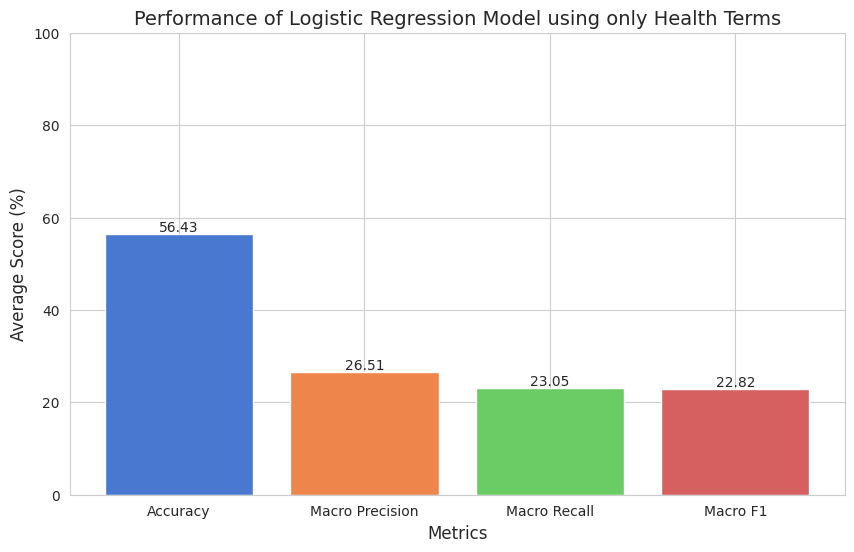

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Average scores
avg_scores = [avg_accuracy*100, avg_macro_precision*100, avg_macro_recall*100, avg_macro_f1*100]
metrics = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1']

# create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, avg_scores, color=sns.color_palette("muted", n_colors=4))

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Average Score (%)', fontsize=12)
plt.title('Performance of Logistic Regression Model using only Health Terms', fontsize=14)
plt.ylim(0, 100)  # Set y-axis range to 0-100%

# Show the plot
plt.show()


Observation: Though the performance isn't stellar, this does show that the imbalance of classes among the subset of health terms alone does give the model some insight. This could cause a problem when we attempt to generalize.

# CNN Network with GloVe embeddings
## Baseline Parameter Settings

To build our baseline, we reference the paper: "Figurative Usage Detection of Symptom Words to Improve Personal Health Mention Detection" (a link is below).

Here is a list of their settings, and we did our best to recreate their model for our baseline:<p>

1. **PHMD**: Filters=100, Kernels=(3, 4, 5), Pool size=2; Dropout=(0.2, 0.3, 0.5).
2. **Figurative Usage Detection**: The figurative la- bel is predicted using a threshold for the literal usage score. This threshold is set to 0.2. This holds for both +Pipeline and +FeatAug. In the case of +Pipeline, a tweet is predicted as fig- urative, and, as a result, non-PHM, if the lit- eral usage score is lower than 0.2. In the case of +FeatAug, the figurative label based on the score is added along with other features.
3. Filters=100; Kernel size (left)=(3, 4, 5), Pool size=2; Dropout=(0.3, 0.1, 0.3); Kernel size (right)=2.
All experiments use the Adam optimiser and a batch size of 128, and trained for 35 epochs. CNN experiments use the ReLU activation. We use seven types of initialisations for the word em- beddings. The first four are a random initialisa- tion, and three pre-trained embeddings. The pre- trained embeddings are: (a) word2vec (Mikolov et al., 2013); (b) GloVe (trained on Common Crawl) (Pennington et al., 2014); and, (c) Num- berbatch (Speer et al., 2017). The next three are embeddings retrofitted with three ontologies. We use three ontologies to retrofit GloVe embeddings using the method by Faruqui et al. (2015). The ontologies are: (a) MeSH,2 (b) Symptom3, and (c) WordNet (Miller, 1995). The results are averaged across 10-fold cross-validation.

https://aclanthology.org/P19-1108.pdf


In [ ]:
# Prepep data for model

encoded_labels = pd.get_dummies(df.rating).values
sequences_X = tokenizer.texts_to_sequences(df.tokens.values)
data = pad_sequences(sequences_X, maxlen=144, truncating='post', padding='post')


### CNN Baseline with Cross-Validation

In [ ]:
# CNN Baseline Model - GloVe embeddings

# Vocab size
vocab_size = len(tokenizer.word_index) + 1

# Input
input_layer = tf.keras.Input(shape=(144,))

# Embed with GloVe weights
embedded = tf.keras.layers.Embedding(input_dim=vocab_size,
                                     output_dim=100,
                                     weights=[embedding_matrix],
                                     trainable=False)(input_layer)

# Convolutional layers and dropout
conv1 = tf.keras.layers.Conv1D(filters=100, kernel_size=3, activation='relu')(embedded)
pooling1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)
dropout1 = tf.keras.layers.Dropout(.2)(pooling1)

conv2 = tf.keras.layers.Conv1D(filters=4, kernel_size=4, activation='relu')(dropout1)
pooling2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv2)
dropout2 = tf.keras.layers.Dropout(.3)(pooling2)

conv3 = tf.keras.layers.Conv1D(filters=4, kernel_size=5, activation='relu')(dropout2)
pooling3 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv3)
dropout3 = tf.keras.layers.Dropout(.5)(pooling3)

# Flatten for output
flattened = tf.keras.layers.Flatten()(dropout3)
output = tf.keras.layers.Dense(3, activation='softmax')(flattened)

#K-Fold
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

X = data  # tokenized and padded sequences
y = encoded_labels  # labels

accuracies = []
macro_precisions = []
macro_recalls = []
macro_f1s = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create a fresh model for each fold
    model_cnn = tf.keras.Model(inputs=input_layer, outputs=output)
    model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', macro_precision, macro_recall, macro_f1])

    model_cnn.fit(X_train, y_train, epochs=32, batch_size=128)

    # Evaluate the model on the validation set
    loss, acc, m_precision, m_recall, m_f1 = model_cnn.evaluate(X_val, y_val)

    accuracies.append(acc)
    macro_precisions.append(m_precision)
    macro_recalls.append(m_recall)
    macro_f1s.append(m_f1)

# Calculate average scores
avg_accuracy = np.mean(accuracies)
avg_macro_precision = np.mean(macro_precisions)
avg_macro_recall = np.mean(macro_recalls)
avg_macro_f1 = np.mean(macro_f1s)

print(f"Average Accuracy: {avg_accuracy*100:.2f}%")
print(f"Average Macro Precision: {avg_macro_precision*100:.2f}%")
print(f"Average Macro Recall: {avg_macro_recall*100:.2f}%")
print(f"Average Macro F1 Score: {avg_macro_f1*100:.2f}%")



Epoch 1/32
69/69 [==============================] - 9s 106ms/step - loss: 1.0889 - accuracy: 0.3803 - macro_precision: 0.1619 - macro_recall: 0.0225 - macro_f1: 0.0362
Epoch 2/32
69/69 [==============================] - 19s 282ms/step - loss: 1.0414 - accuracy: 0.4394 - macro_precision: 0.2710 - macro_recall: 0.0775 - macro_f1: 0.1151
Epoch 3/32
69/69 [==============================] - 11s 164ms/step - loss: 1.0069 - accuracy: 0.4814 - macro_precision: 0.4039 - macro_recall: 0.1247 - macro_f1: 0.1845
Epoch 4/32
69/69 [==============================] - 8s 120ms/step - loss: 0.9273 - accuracy: 0.5523 - macro_precision: 0.5408 - macro_recall: 0.2796 - macro_f1: 0.3652
Epoch 5/32
69/69 [==============================] - 11s 153ms/step - loss: 0.8614 - accuracy: 0.6099 - macro_precision: 0.6530 - macro_recall: 0.3296 - macro_f1: 0.4341
Epoch 6/32
69/69 [==============================] - 8s 109ms/step - loss: 0.8380 - accuracy: 0.6304 - macro_precision: 0.6823 - macro_recall: 0.3435 - macro_

### CNN Baseline on Test Data

In [ ]:
#CNN on Test Set
#Reinitialize the model

# Vocab size
vocab_size = len(tokenizer.word_index) + 1

# Input
input_layer = tf.keras.Input(shape=(144,))

# Embed with GloVe weights
embedded = tf.keras.layers.Embedding(input_dim=vocab_size,
                                     output_dim=100,
                                     weights=[embedding_matrix],
                                     trainable=False)(input_layer)

# Convolutional layers and dropout
conv1 = tf.keras.layers.Conv1D(filters=100, kernel_size=3, activation='relu')(embedded)
pooling1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)
dropout1 = tf.keras.layers.Dropout(.2)(pooling1)

conv2 = tf.keras.layers.Conv1D(filters=4, kernel_size=4, activation='relu')(dropout1)
pooling2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv2)
dropout2 = tf.keras.layers.Dropout(.3)(pooling2)

conv3 = tf.keras.layers.Conv1D(filters=4, kernel_size=5, activation='relu')(dropout2)
pooling3 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv3)
dropout3 = tf.keras.layers.Dropout(.5)(pooling3)

# Flatten for output
flattened = tf.keras.layers.Flatten()(dropout3)
output = tf.keras.layers.Dense(3, activation='softmax')(flattened)

model_cnn = tf.keras.Model(inputs=input_layer, outputs=output)
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', macro_precision, macro_recall, macro_f1])


# Train the model on the full training set
X_train = tokenizer.texts_to_sequences(train_df['tokens'])
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=144)
y_train = pd.get_dummies(train_df['rating']).values
history = model_cnn.fit(X_train, y_train, epochs=15, batch_size=128)

# Tokenize and pad the text data in test_df
X_test = tokenizer.texts_to_sequences(test_df['tokens'])
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=144)

# Encode the labels (if they are categorical)
y_test = pd.get_dummies(test_df['rating']).values

# Train the model on the full training set
history = model_cnn.fit(X_train, y_train, epochs=15, batch_size=128)

# Predict on the test data
y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Macro Precision: {precision*100:.2f}%")
print(f"Test Macro Recall: {recall*100:.2f}%")
print(f"Test Macro F1 Score: {f1*100:.2f}%")


Epoch 1/15
69/69 [==============================] - 8s 99ms/step - loss: 1.0952 - accuracy: 0.3618 - macro_precision: 0.1071 - macro_recall: 0.0087 - macro_f1: 0.0154
Epoch 2/15
69/69 [==============================] - 10s 144ms/step - loss: 1.0651 - accuracy: 0.4689 - macro_precision: 0.3065 - macro_recall: 0.0446 - macro_f1: 0.0760
Epoch 3/15
69/69 [==============================] - 7s 105ms/step - loss: 1.0225 - accuracy: 0.5212 - macro_precision: 0.3889 - macro_recall: 0.0978 - macro_f1: 0.1545
Epoch 4/15
69/69 [==============================] - 10s 141ms/step - loss: 0.9947 - accuracy: 0.5236 - macro_precision: 0.3906 - macro_recall: 0.1146 - macro_f1: 0.1749
Epoch 5/15
69/69 [==============================] - 7s 100ms/step - loss: 0.9675 - accuracy: 0.5345 - macro_precision: 0.5531 - macro_recall: 0.1692 - macro_f1: 0.2558
Epoch 6/15
69/69 [==============================] - 9s 131ms/step - loss: 0.9359 - accuracy: 0.5523 - macro_precision: 0.5866 - macro_recall: 0.3024 - macro_f1

32/32 [==============================] - 1s 16ms/step


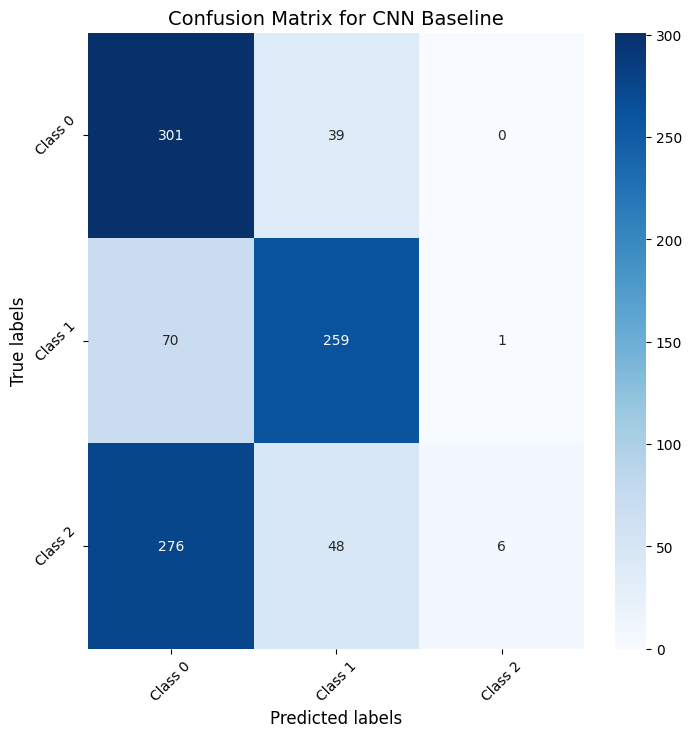

In [ ]:
# Confusion Matrix
predictions = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

graph_confusion_matrix(conf_matrix,'CNN Baseline')


Observation: F1 score improves quite a bit over simple logistic regression, indicating it is picking up some pattern in the text beyond the health term identifiers.

This F1 score is slightly better than the one in the paper. Though we did our best to replicate. their model it is likely that the gloVE embeddings have improved over the years.

# -- Feature Engineering Enhancements --

Before moving to more complicated models using transformers, we want to see if we can improve on the CNN by helping it identify patterns. We used the spaCy librar, a ibrary for advanced natural language processing. We will also test if LSTMs can improve the score with its increased ability to detect dependency.

## Experiment 1 - LSTM

This first experiment will see is LSTM alone can improve upon the CNN baseline F1 score of 58.19

In [ ]:
#LSTM on Test Set

# Vocab size
vocab_size = len(tokenizer.word_index) + 1

# Input
input_layer = tf.keras.Input(shape=(144,))

# Embed with GloVe weights
embedded = tf.keras.layers.Embedding(input_dim=vocab_size,
                                     output_dim=100,
                                     weights=[embedding_matrix],
                                     trainable=False)(input_layer)

# LSTM layers and dropout
lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedded)
dropout1 = tf.keras.layers.Dropout(0.4)(lstm1)

lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(dropout1)
dropout2 = tf.keras.layers.Dropout(0.5)(lstm2)

lstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(dropout1)
dropout3 = tf.keras.layers.Dropout(0.4)(lstm3)

# Dense output layer
output = tf.keras.layers.Dense(3, activation='softmax')(dropout3)

model = tf.keras.Model(inputs=input_layer, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=.0002)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', macro_precision, macro_recall, macro_f1])
history = model.fit(X_train, y_train, epochs=15, batch_size=128)


# Train the model on the full training set
X_train = tokenizer.texts_to_sequences(train_df['tokens'])
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=144)
y_train = pd.get_dummies(train_df['rating']).values
history = model.fit(X_train, y_train, epochs=15, batch_size=128)

# Tokenize and pad the text data in test_df
X_test = tokenizer.texts_to_sequences(test_df['tokens'])
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=144)

# Encode the labels (if they are categorical)
y_test = pd.get_dummies(test_df['rating']).values

# Predict on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Macro Precision: {precision*100:.2f}%")
print(f"Test Macro Recall: {recall*100:.2f}%")
print(f"Test Macro F1 Score: {f1*100:.2f}%")


Epoch 1/15
69/69 [==============================] - 90s 1s/step - loss: 0.9648 - accuracy: 0.5307 - macro_precision: 0.5340 - macro_recall: 0.1540 - macro_f1: 0.2242
Epoch 2/15
69/69 [==============================] - 75s 1s/step - loss: 0.8105 - accuracy: 0.6385 - macro_precision: 0.7060 - macro_recall: 0.4551 - macro_f1: 0.5516
Epoch 3/15
69/69 [==============================] - 88s 1s/step - loss: 0.7172 - accuracy: 0.7103 - macro_precision: 0.7669 - macro_recall: 0.6149 - macro_f1: 0.6819
Epoch 4/15
69/69 [==============================] - 80s 1s/step - loss: 0.6656 - accuracy: 0.7375 - macro_precision: 0.7815 - macro_recall: 0.6777 - macro_f1: 0.7256
Epoch 5/15
69/69 [==============================] - 67s 980ms/step - loss: 0.6322 - accuracy: 0.7528 - macro_precision: 0.7994 - macro_recall: 0.7001 - macro_f1: 0.7462
Epoch 6/15
69/69 [==============================] - 66s 953ms/step - loss: 0.6139 - accuracy: 0.7655 - macro_precision: 0.8076 - macro_recall: 0.7201 - macro_f1: 0.761

32/32 [==============================] - 3s 104ms/step


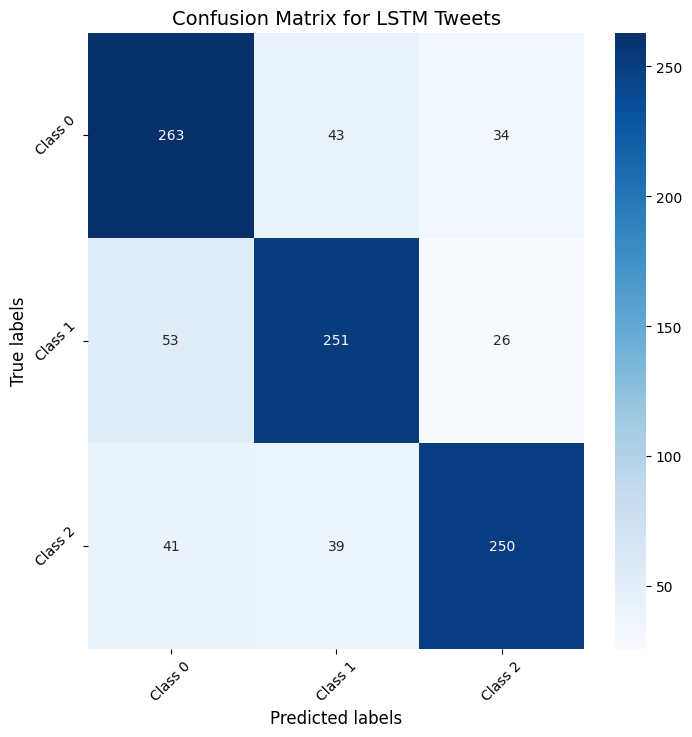

In [ ]:
#Confusion Matrix on LSTM Test Subset

predictions = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

graph_confusion_matrix(conf_matrix,'LSTM Tweets')

Observation: LSTM improves on our CNN baseline F1 score, while also handling class 2 much better.

### Experiment 2 LSTM with Masked out Health Term

> Indented block


This model is the same as the previous LTSM but health terms are masked in tweets. Instead of 'gun violence is a cancer' it would read 'gun violence is a blank.'

In [ ]:
#LSTM on Blank Test Set

# Vocab size
vocab_size = len(tokenizer.word_index) + 1

# Input
input_layer = tf.keras.Input(shape=(144,))

# Embed with GloVe weights
embedded = tf.keras.layers.Embedding(input_dim=vocab_size,
                                     output_dim=100,
                                     weights=[embedding_matrix],
                                     trainable=True)(input_layer)

# LSTM layers and dropout
lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedded)
dropout1 = tf.keras.layers.Dropout(0.4)(lstm1)

lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(dropout1)
dropout2 = tf.keras.layers.Dropout(0.5)(lstm2)

lstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(dropout1)
dropout3 = tf.keras.layers.Dropout(0.4)(lstm3)

# Dense output layer
output = tf.keras.layers.Dense(3, activation='softmax')(dropout3)

model_blank = tf.keras.Model(inputs=input_layer, outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=.0002)
model_blank.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', macro_precision, macro_recall, macro_f1])



# Train the model on the full training set
X_train = tokenizer.texts_to_sequences(train_df['modified_tokens'])
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=144)
y_train = pd.get_dummies(train_df['rating']).values
history = model_blank.fit(X_train, y_train, epochs=15, batch_size=128)

# Tokenize and pad the text data in test_df
X_test = tokenizer.texts_to_sequences(test_df['modified_tokens'])
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=144)

# Encode the labels (if they are categorical)
y_test = pd.get_dummies(test_df['rating']).values

# Predict on the test data
y_pred = model_blank.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Macro Precision: {precision*100:.2f}%")
print(f"Test Macro Recall: {recall*100:.2f}%")
print(f"Test Macro F1 Score: {f1*100:.2f}%")


Epoch 1/15
69/69 [==============================] - 83s 1s/step - loss: 0.9826 - accuracy: 0.5163 - macro_precision: 0.4739 - macro_recall: 0.1275 - macro_f1: 0.1890
Epoch 2/15
69/69 [==============================] - 75s 1s/step - loss: 0.8004 - accuracy: 0.6410 - macro_precision: 0.7118 - macro_recall: 0.4665 - macro_f1: 0.5620
Epoch 3/15
69/69 [==============================] - 75s 1s/step - loss: 0.6892 - accuracy: 0.7251 - macro_precision: 0.7787 - macro_recall: 0.6370 - macro_f1: 0.7004
Epoch 4/15
69/69 [==============================] - 73s 1s/step - loss: 0.6261 - accuracy: 0.7637 - macro_precision: 0.8068 - macro_recall: 0.7039 - macro_f1: 0.7515
Epoch 5/15
69/69 [==============================] - 73s 1s/step - loss: 0.5809 - accuracy: 0.7804 - macro_precision: 0.8199 - macro_recall: 0.7306 - macro_f1: 0.7724
Epoch 6/15
69/69 [==============================] - 76s 1s/step - loss: 0.5440 - accuracy: 0.7946 - macro_precision: 0.8304 - macro_recall: 0.7526 - macro_f1: 0.7894
Epoc

32/32 [==============================] - 2s 72ms/step


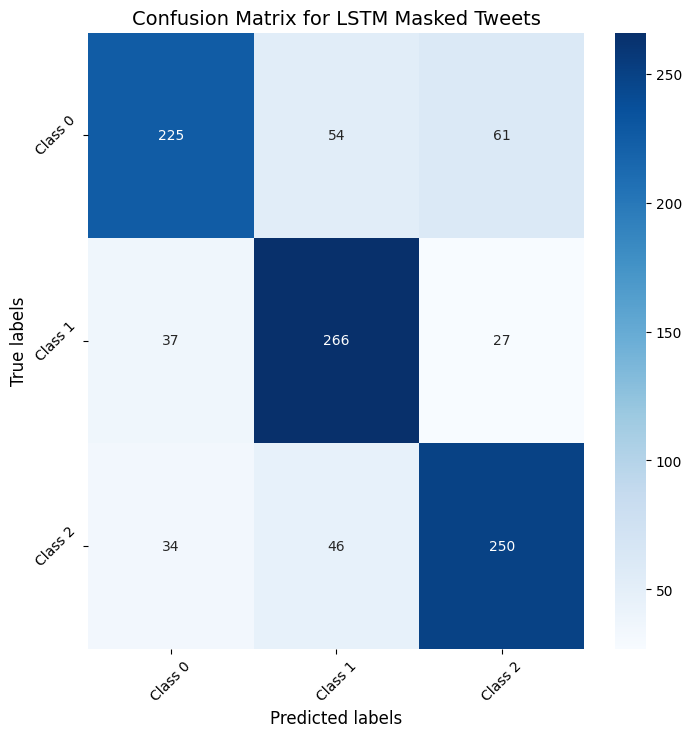

In [ ]:
# Confusion Matrix on Masked Tweets
predictions = model_blank.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

graph_confusion_matrix(conf_matrix,'LSTM Masked Tweets')


Observation: Even by masking out health terms, the LSTM still performs well on the tweets. This is a good sign as our earlier worry was that class imbalance in the subset of health terms might create issues.

### Experiment 3 LSTM on Part-of-Speech Tweets from spaCy
Here we are trying to see if the LSTM model has any success in picking up patterns by just looking at part-of-speech. So, 'the brown dog ran' would become: 'article adj noun verb'.

Ultimately we want to see if we can assist the models in finding patterns.

In [ ]:
#LSTM on Part-of-Speech Test Set

# Vocab size
vocab_size = len(tokenizer.word_index) + 1

# Input
input_layer = tf.keras.Input(shape=(144,))

# Embed with GloVe weights
embedded = tf.keras.layers.Embedding(input_dim=vocab_size,
                                     output_dim=100,
                                     weights=[embedding_matrix],
                                     trainable=False)(input_layer)

# LSTM layers and dropout
lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedded)
dropout1 = tf.keras.layers.Dropout(0.4)(lstm1)

lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(dropout1)
dropout2 = tf.keras.layers.Dropout(0.5)(lstm2)

lstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(dropout1)
dropout3 = tf.keras.layers.Dropout(0.4)(lstm3)

# Dense output layer
output = tf.keras.layers.Dense(3, activation='softmax')(dropout3)
model_pos = tf.keras.Model(inputs=input_layer, outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=.0002)
model_pos.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', macro_precision, macro_recall, macro_f1])

# Prepare training data
X_train = tokenizer.texts_to_sequences(train_df['pos_tokens'])
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=144)
y_train = pd.get_dummies(train_df['rating']).values

# Train the model
history = model_pos.fit(X_train, y_train, epochs=15, batch_size=128)

# Prepare test data
X_test = tokenizer.texts_to_sequences(test_df['pos_tokens'])
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=144)
y_test = pd.get_dummies(test_df['rating']).values

# Predict on test data
y_pred = model_pos.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print metrics
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Macro Precision: {precision*100:.2f}%")
print(f"Test Macro Recall: {recall*100:.2f}%")
print(f"Test Macro F1 Score: {f1*100:.2f}%")


Epoch 1/15
69/69 [==============================] - 74s 931ms/step - loss: 1.0217 - accuracy: 0.4958 - macro_precision: 0.3255 - macro_recall: 0.0632 - macro_f1: 0.0991
Epoch 2/15
69/69 [==============================] - 72s 1s/step - loss: 0.8168 - accuracy: 0.6485 - macro_precision: 0.7329 - macro_recall: 0.4621 - macro_f1: 0.5607
Epoch 3/15
69/69 [==============================] - 64s 919ms/step - loss: 0.7044 - accuracy: 0.7148 - macro_precision: 0.7666 - macro_recall: 0.6362 - macro_f1: 0.6949
Epoch 4/15
69/69 [==============================] - 61s 888ms/step - loss: 0.6583 - accuracy: 0.7405 - macro_precision: 0.7899 - macro_recall: 0.6768 - macro_f1: 0.7287
Epoch 5/15
69/69 [==============================] - 64s 915ms/step - loss: 0.6262 - accuracy: 0.7585 - macro_precision: 0.7977 - macro_recall: 0.7005 - macro_f1: 0.7457
Epoch 6/15
69/69 [==============================] - 62s 904ms/step - loss: 0.6092 - accuracy: 0.7670 - macro_precision: 0.8023 - macro_recall: 0.7144 - macro_

32/32 [==============================] - 3s 93ms/step


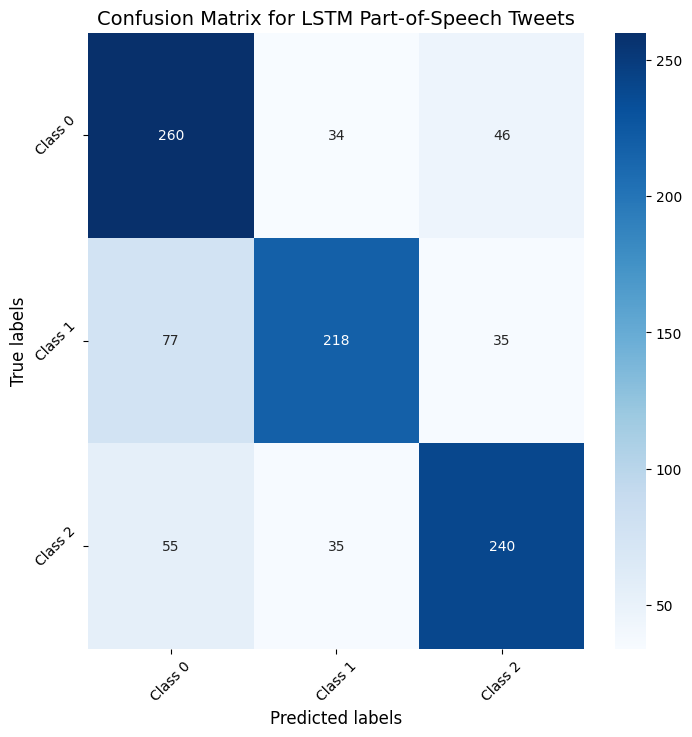

In [ ]:
# Confusion Matrix on Part-of-Speech Tweets
predictions = model_pos.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

graph_confusion_matrix(conf_matrix,'LSTM Part-of-Speech Tweets')

Observation: This was the biggest surprise. LSTM performed surprisingly well by training only on the parts-of-speech of the tweet, showing that the LSTM is picking up on some underlying patterns.

## Experiment 4 - LSTM and CNN

Finally, tried having CNN look at the tweet and LSTM look at part-of-speaches of tweet, and see if we can boost the score.

In [ ]:
#LSTM Pos and CNN

# LSTM Branch
input_lstm = tf.keras.Input(shape=(144,))
embedded_lstm = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], trainable=False)(input_lstm)
lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedded_lstm)
dropout_lstm1 = tf.keras.layers.Dropout(0.4)(lstm1)
lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(dropout_lstm1)
dropout_lstm2 = tf.keras.layers.Dropout(0.5)(lstm2)
# lstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(dropout_lstm2)
# dropout_lstm3 = tf.keras.layers.Dropout(0.4)(lstm3)

# CNN Branch
input_cnn = tf.keras.Input(shape=(144,))
embedded_cnn = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], trainable=False)(input_cnn)
conv1 = tf.keras.layers.Conv1D(filters=100, kernel_size=3, activation='relu')(embedded_cnn)
pooling1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)
dropout_cnn1 = tf.keras.layers.Dropout(.4)(pooling1)
conv2 = tf.keras.layers.Conv1D(filters=4, kernel_size=4, activation='relu')(dropout_cnn1)
pooling2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv2)
dropout_cnn2 = tf.keras.layers.Dropout(.5)(pooling2)
conv3 = tf.keras.layers.Conv1D(filters=4, kernel_size=5, activation='relu')(dropout_cnn2)
pooling3 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv3)
dropout_cnn3 = tf.keras.layers.Dropout(.6)(pooling3)
flattened_cnn = tf.keras.layers.Flatten()(dropout_cnn3)

# Concatenate LSTM and CNN outputs
concatenated = tf.keras.layers.concatenate([dropout_lstm2, flattened_cnn])

# Dense layer for classification
output = tf.keras.layers.Dense(3, activation='softmax')(concatenated)

# Combined Model
model_combined = tf.keras.Model(inputs=[input_lstm, input_cnn], outputs=output)

# Compile the model
model_combined.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', macro_precision, macro_recall, macro_f1])

# Prepare the data for training
# Tokenize and pad the text data for both LSTM and CNN inputs
X_train_lstm = tokenizer.texts_to_sequences(train_df['pos_tokens'])
X_train_lstm = tf.keras.preprocessing.sequence.pad_sequences(X_train_lstm, maxlen=144)
X_train_cnn = tokenizer.texts_to_sequences(train_df['tokens'])
X_train_cnn = tf.keras.preprocessing.sequence.pad_sequences(X_train_cnn, maxlen=144)
y_train = pd.get_dummies(train_df['rating']).values

# Train the model on the full training set
history = model_combined.fit([X_train_lstm, X_train_cnn], y_train, epochs=15, batch_size=128)

# Prepare the test data in the same way
X_test_lstm = tokenizer.texts_to_sequences(test_df['pos_tokens'])
X_test_lstm = tf.keras.preprocessing.sequence.pad_sequences(X_test_lstm, maxlen=144)
X_test_cnn = tokenizer.texts_to_sequences(test_df['tokens'])
X_test_cnn = tf.keras.preprocessing.sequence.pad_sequences(X_test_cnn, maxlen=144)
y_test = pd.get_dummies(test_df['rating']).values

# Predict on the test data
y_pred = model_combined.predict([X_test_lstm, X_test_cnn])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Macro Precision: {precision*100:.2f}%")
print(f"Test Macro Recall: {recall*100:.2f}%")
print(f"Test Macro F1 Score: {f1*100:.2f}%")


Epoch 1/15
69/69 [==============================] - 85s 1s/step - loss: 0.8859 - accuracy: 0.5978 - macro_precision: 0.6155 - macro_recall: 0.3695 - macro_f1: 0.4378
Epoch 2/15
69/69 [==============================] - 73s 1s/step - loss: 0.6732 - accuracy: 0.7381 - macro_precision: 0.7882 - macro_recall: 0.6757 - macro_f1: 0.7270
Epoch 3/15
69/69 [==============================] - 77s 1s/step - loss: 0.6016 - accuracy: 0.7745 - macro_precision: 0.8148 - macro_recall: 0.7370 - macro_f1: 0.7738
Epoch 4/15
69/69 [==============================] - 76s 1s/step - loss: 0.5281 - accuracy: 0.8077 - macro_precision: 0.8367 - macro_recall: 0.7729 - macro_f1: 0.8033
Epoch 5/15
69/69 [==============================] - 72s 1s/step - loss: 0.4868 - accuracy: 0.8230 - macro_precision: 0.8519 - macro_recall: 0.7925 - macro_f1: 0.8210
Epoch 6/15
69/69 [==============================] - 72s 1s/step - loss: 0.4559 - accuracy: 0.8337 - macro_precision: 0.8616 - macro_recall: 0.8073 - macro_f1: 0.8334
Epoc

32/32 [==============================] - 3s 85ms/step


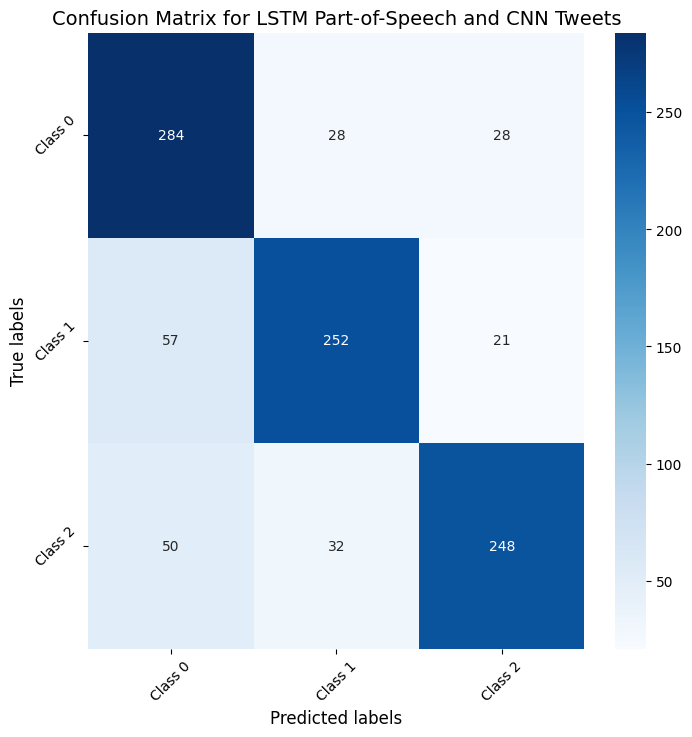

In [ ]:
# LSTM Part-of-Speech and CNN Tweets
predictions = model_combined.predict([X_test_lstm,X_test_cnn])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

graph_confusion_matrix(conf_matrix,'LSTM Part-of-Speech and CNN Tweets')

Observation: Though this improved the F1 score over the LSTM by roughly 2%, the added complexity of the model may not be worth it.

# Further Performance Analysis of CNN Baseline Model
Here we wanted to take a granular look at how the CNN Baseline model performs on individual tweets.

# Examine Performance

In [ ]:
# append prediction success to df

predictions = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

correct_predictions = y_pred_classes == y_true_classes


test_df['correct'] = correct_predictions
df_test_result = test_df


32/32 [==============================] - 1s 17ms/step


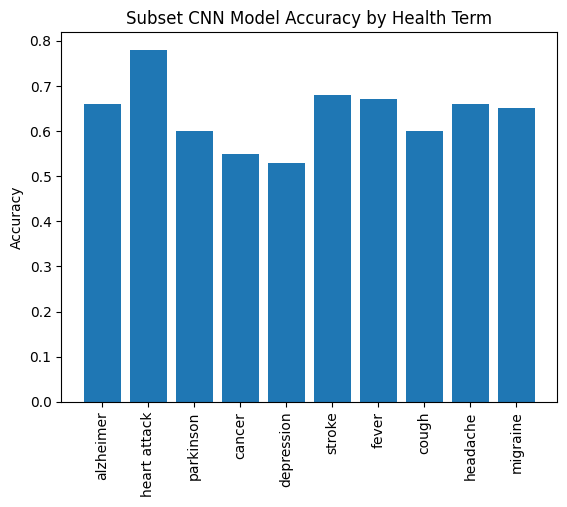

In [ ]:
#check accuracy on subset of health words

hw_acc = []

for word in health_words:
  tp = len(df_test_result.loc[(df_test_result.correct==True) & (df_test_result.health_word==word)])
  total = len(df_test_result.loc[(df_test_result.health_word==word)])
  hw_acc.append(round(tp/total,2))

plt.bar(health_words,hw_acc)

# Rotate x-ticks to make them vertical
plt.xticks(rotation='vertical')

# Set the y-label to 'Accuracy'
plt.ylabel('Accuracy')

# Remove the x-label
plt.xlabel('')

# Set the title of the plot
plt.title('Subset CNN Model Accuracy by Health Term')

# Display the plot
plt.show()



In [ ]:
# print TP and FN results split by class and health term

pd.set_option('display.max_colwidth', None)
rating_0 ={}
rating_1 ={}
rating_2 ={}
for word in health_words:
  for i in range(3):
    correct = (df_test_result.loc[(df_test_result.correct==True) & (df_test_result.health_word==word) &\
                                  (df_test_result.rating==i)]).iloc[0:1].text
    incorrect = (df_test_result.loc[(df_test_result.correct==False) & (df_test_result.health_word==word) &\
                                (df_test_result.rating==i)]).iloc[0:1].text

    if i == 0:
      rating_0[word] = [incorrect,correct]
    elif i == 1:
      rating_1[word] = [incorrect,correct]
    else:
      rating_2[word] = [incorrect,correct]

print('-------Class 0-------------')
print('')
for key, values in rating_0.items():
  print(f'{key}:')
  print('_____________')
  print(f'TP: {values[1]}')
  print(f'FN: {values[0]}')
  print('')

print('-------Class 1-------------')

for key, values in rating_1.items():
  print(f'{key}:')
  print('_____________')
  print(f'TP: {values[1]}')
  print(f'FN: {values[0]}')
  print('')

print('-------Class 2-------------')

for key, values in rating_2.items():
  print(f'{key}:')
  print('_____________')
  print(f'TP: {values[1]}')
  print(f'FN: {values[0]}')
  print('')


-------Class 0-------------

alzheimer:
_____________
TP: 55    Niggas send u pics of wat they used to look like back in the day when they were skinny and cute and when u meet up wit them they all fat and got  Alzheimer's  talkin bout I thought I sent a recent pic bitch u knew I wasn't meetin up with yo ugly ass 😂😂😂😂
Name: text, dtype: object
FN: 54    Hillary and the DNC are the ones who got help from hostile foreign powers. Does that fact keep slipping your mind? Maybe you have Alzheimer’s. In any case, Americans are sick and tired of all the Russia crap. Please, Dems, for the love of God, do us all a favor and move on! https://t.co/vhtlMnbgEG
Name: text, dtype: object

heart attack:
_____________
TP: 26    @Ms_HeartAttack missed it😭 about to tho👏
Name: text, dtype: object
FN: 271    Some girls holding up a banner were playing boyfriend I almost had a heart attack
Name: text, dtype: object

parkinson:
_____________
TP: 24    That just sealed Trumps re-election. Mueller looked and sou

# Tryout Models

In [ ]:
# Test individual Tweets

def preprocess_tweet(tweet, tokenizer, max_length):
    # Tokenize the tweet
    sequence = tokenizer.texts_to_sequences([tweet])

    # Pad the sequence
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_length)

    return padded_sequence

def predict_tweet(tweet, model, tokenizer, max_length):
    # Preprocess the tweet
    processed_tweet = preprocess_tweet(tweet, tokenizer, max_length)

    # Predict
    prediction = model_cnn.predict(processed_tweet)

    # get highest probability
    predicted_class = np.argmax(prediction, axis=1)

    return predicted_class

# test a tweeet
tweet = "her music gives me a migraine"
max_length = 144
predicted_class = predict_tweet(tweet, model_cnn, tokenizer, max_length)

print(f"Predicted class for the tweet: {predicted_class}")


1/1 [==============================] - 0s 153ms/step
Predicted class for the tweet: [0]


In [ ]:
# Convert to DataFrame
results_df = pd.DataFrame({
    'tweet_id': test_df['tweet_id'],
    'text': test_df['text'],
    'rating': y_true_classes,
    'predicted_rating': y_pred_classes
})

# Calculate 'correct' column
results_df['correct'] = results_df['rating'] == results_df['predicted_rating']

# Calculate 'incorrect_prediction' column
results_df['incorrect_prediction'] = results_df.apply(
    lambda row: row['predicted_rating'] if not row['correct'] else None, axis=1)

# drop predicted rating
results_df.drop('predicted_rating', axis=1, inplace=True)

# Save to CSV
from google.colab import files
files.download('test_results.csv')
